In [966]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import nolds
from math import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [967]:
# Condiciones iniciales

x_0 = 1 # Posición inicial (arb)
v_0 = 0 # Velocidad inicial (arb)

# Definiciones iniciales

w_0 = 0.5 # Frecuencia natural x>0
W_0 = 100 # Frecuencia natural x<0
amort = 0.125 # constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa

dt = 0.001 # Paso de tiempo
tf = 500 # Tiempo de medida (se asume que t0 = 0)
t = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [968]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

In [969]:
dw = 0.001 # paso en la frecuencia externa
w =  np.array([i*dw for i in range(int(1.2/dw),int(1.6/dw)+1)]) # Frecuencia fuerza externa

In [970]:
def EDO(x,y,w):
    return np.array([y[1],-2*amort*y[1]-W(y[0])**2*y[0]+f_0*np.cos(w*x)])

In [971]:
# Resolución numérica de la ecuación diferencial

def RK4(EDO, x0, y0, xf, h, w):

    # EDO: Array de ecuaciones diferenciales de primer orden
    # x0: valor inicial de la variable independiente
    # y0: valor de la variable dependiente evaluada en x = x0 (condición inicial si x=0)
    # xf: valor final de la variable independiente
    # h: tamaño del paso
    # w: frecuencia externa

    m = 2

    n = round((xf-x0)/h)+1 # Calculamos el número de puntos
    
    x = np.empty(n) # Creamos arrays donde almacenar la solución
    y = np.empty([n,m])
    k1,k2,k3,k4= np.empty(m),np.empty(m),np.empty(m),np.empty(m)

    x[0] = x0 # Aplicamos las condiciones iniciales
    for j in range(m):
        y[0,j] = y0[j]
    
    for i in range(n-1): # Implementamos el método RK4
        x[i] = x0+i*h
        for j in range(m):
            k1[j] = h*EDO(x[i],y[i,:],w)[j]
        for j in range(m):
            k2[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k1,w)[j]
        for j in range(m):
            k3[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k2,w)[j]
        for j in range(m):
            k4[j] = h*EDO(x[i]+h,y[i]+k3,w)[j]
        for j in range(m):
            y[i+1,j] = y[i,j]+(1/6)*(k1[j]+2*k2[j]+2*k3[j]+k4[j]);

    x[n-1] = xf
            
    return x,y

In [972]:
def Lyapunov_exponent(N,w,eps,x_0,v_0):
    
    z = np.zeros([N,2])
    zp = np.zeros([N,2])
    d = np.zeros(N)
    loglist = np.zeros(N)

    z[0] = [x_0,v_0]
    zp[0] = [x_0+eps/sqrt(2),v_0+eps/sqrt(2)]
    d[0] = eps

    for i in range(1,N):
        ts,y = RK4(EDO,dt*(i-1),z[i-1],dt*i,dt,w) # Resolvemos el sistema
        pos = y[:,0]
        vel = y[:,1]
        tL,yL = RK4(EDO,dt*(i-1),zp[i-1],dt*i,dt,w) # Resolvemos el sistema
        posL = yL[:,0]
        velL = yL[:,1]
        z[i] = [pos[1],vel[1]]
        zp[i] = [posL[1],velL[1]]
        d[i] = np.linalg.norm(z[i]-zp[i])
        loglist[i] = np.log(d[i]/eps)
        #zp[i] = z[i]+(eps/d[i])*(-z[i]+zp[i])

    return [np.mean((loglist/t)[-int(N/10):]),np.std((loglist/t)[-int(N/10):])]

In [973]:
def eps(w):
    if w < 1.5:
        return 1e-3
    else:
        return 1e-4

In [974]:
N = len(t)
lyap = np.zeros(np.size(w))
disp = np.zeros(np.size(w))

for i in range(np.size(w)):
    lyap[i],disp[i] = Lyapunov_exponent(N,w[i],eps(w[i]),x_0,v_0)

C:\Users\rodri\AppData\Local\Temp\ipykernel_7484\1614638344.py:25: RuntimeWarning: invalid value encountered in divide
  return [np.mean((loglist/t)[-int(N/10):]),np.std((loglist/t)[-int(N/10):])]


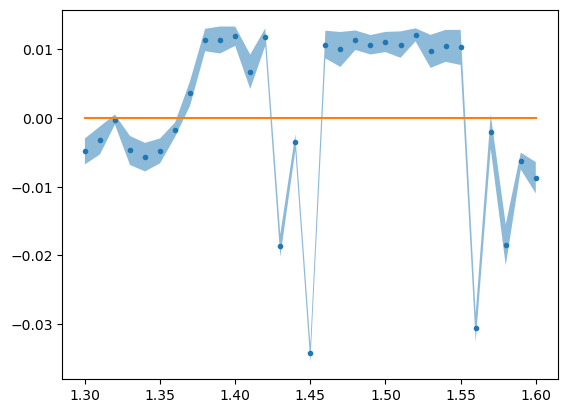

In [ ]:
#plt.errorbar(w,lyap,yerr = disp,fmt=".b",capsize=3,ecolor="k")
plt.fill_between(w,lyap-disp,lyap+disp,alpha = 0.5)
plt.plot(w,lyap,'.')
plt.plot(w,[0]*w.size)